In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

sns.set_style("whitegrid", {'axes.grid' : False})

from tqdm.auto import tqdm

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import cv2
import imutils
import pickle

In [5]:
from utils.utils import open_video, crop_margins, map_frames, get_game_margins, dist

In [6]:
screen_to_frame = pickle.load(open("data/screen_to_frame.p", "rb"))
# screen_to_frame = np.array([v.ravel() for v in screen_to_frame.values()])

0it [00:00, ?it/s]

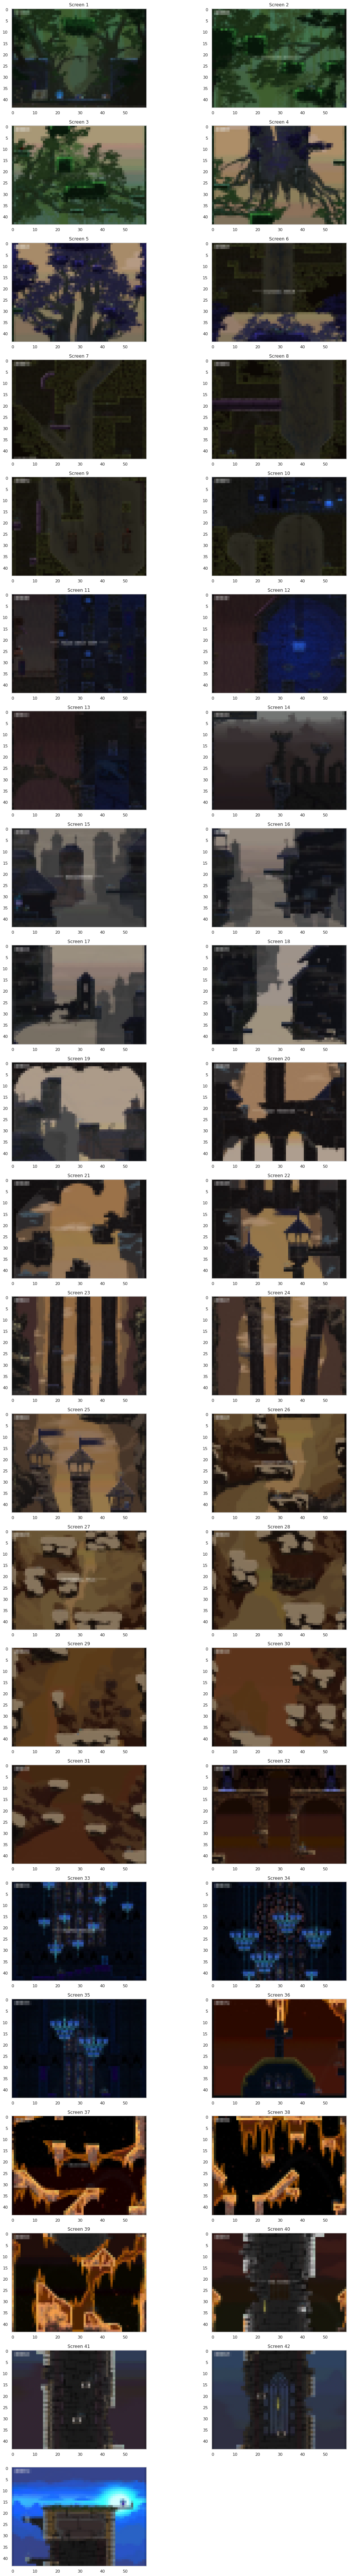

In [8]:
# check if all screens are present

fig, axs = plt.subplots(figsize=(16, 96))

for i, s in tqdm(enumerate(screen_to_frame.values())):
    plt.title(f"Screen {i}")
    plt.subplot(22, 2, i + 1)
    plt.imshow(s)

fig.tight_layout()

getting video start


  0%|          | 0/11277 [00:00<?, ?it/s]

video starts at frame 325
mapping screens


  0%|          | 0/10952 [00:00<?, ?it/s]

done mapping screens


  0%|          | 0/43 [00:00<?, ?it/s]

0 325 492 1
1 492 637 1
2 637 817 1
3 817 964 1
4 964 1165 1
5 1165 1385 1
6 1385 1572 1
7 1572 1770 1
8 1770 2010 1
9 2010 2196 1
10 2196 2302 1
11 2302 2422 1
12 2422 2579 2
13 2579 2598 2
14 2733 2862 1
15 2862 3021 1
16 3021 3281 1
17 3281 3486 1
18 3486 3648 1
19 3648 3770 1
20 3770 3930 1
21 3930 4053 1
22 4053 4228 1
23 4228 4347 1
24 4347 4523 1
25 4523 4696 1
26 4696 4866 1
27 4866 5020 1
28 5020 5289 1
29 5289 5571 1
30 5571 5785 1
31 5785 5988 1
32 5988 6170 1
33 6170 6293 1
34 6293 6494 1
35 6494 6644 1
36 6644 6862 1
37 6862 7105 1
38 7105 7281 1
39 7281 7468 1
40 7468 7618 1
41 7618 7810 1
42 7810 10541 1


0it [00:00, ?it/s]

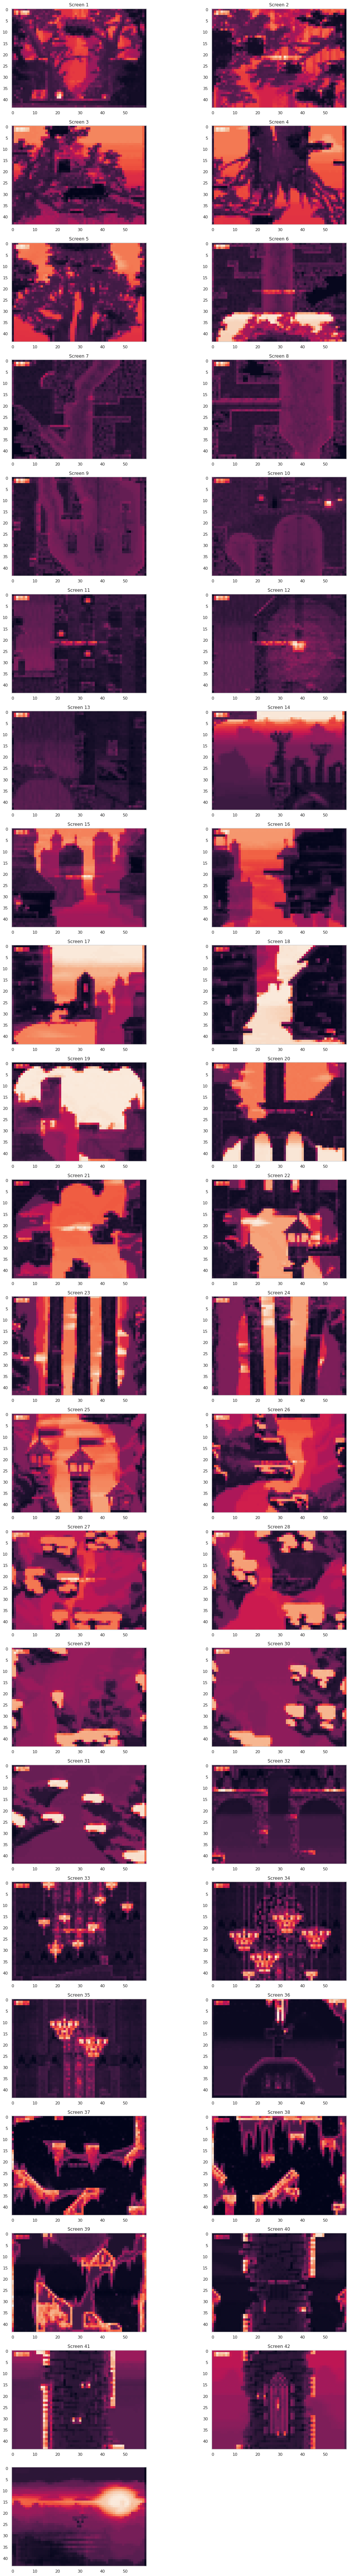

In [9]:
screen_to_frame = pickle.load(open("data/screen_to_frame.p", "rb"))
screen_to_frame = np.array([v.ravel() for v in screen_to_frame.values()])

screen_to_frames, frame_to_screen = map_frames('data/speedrun_side.mp4',
                                               screen_to_frame)

cap = open_video('data/speedrun_side.mp4')
margin_left, margin_right = get_game_margins(cap)
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# make new screen to frame
screen_to_frame = {}
for screen, frames in tqdm(screen_to_frames.items()):
    start, end = frames[0]
    n = end - start
    cap.set(cv2.CAP_PROP_POS_FRAMES, start)
    frames = []
    for i in range(n):
        ret, frame = cap.read()
        if ret == False:
            break

        frame = crop_margins(frame, margin_left, margin_right)
        frame = imutils.resize(frame, width=60)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(frame)

    avg_frame = np.mean(frames, axis=0)
    screen_to_frame[screen] = avg_frame.astype(np.uint8)

0it [00:00, ?it/s]

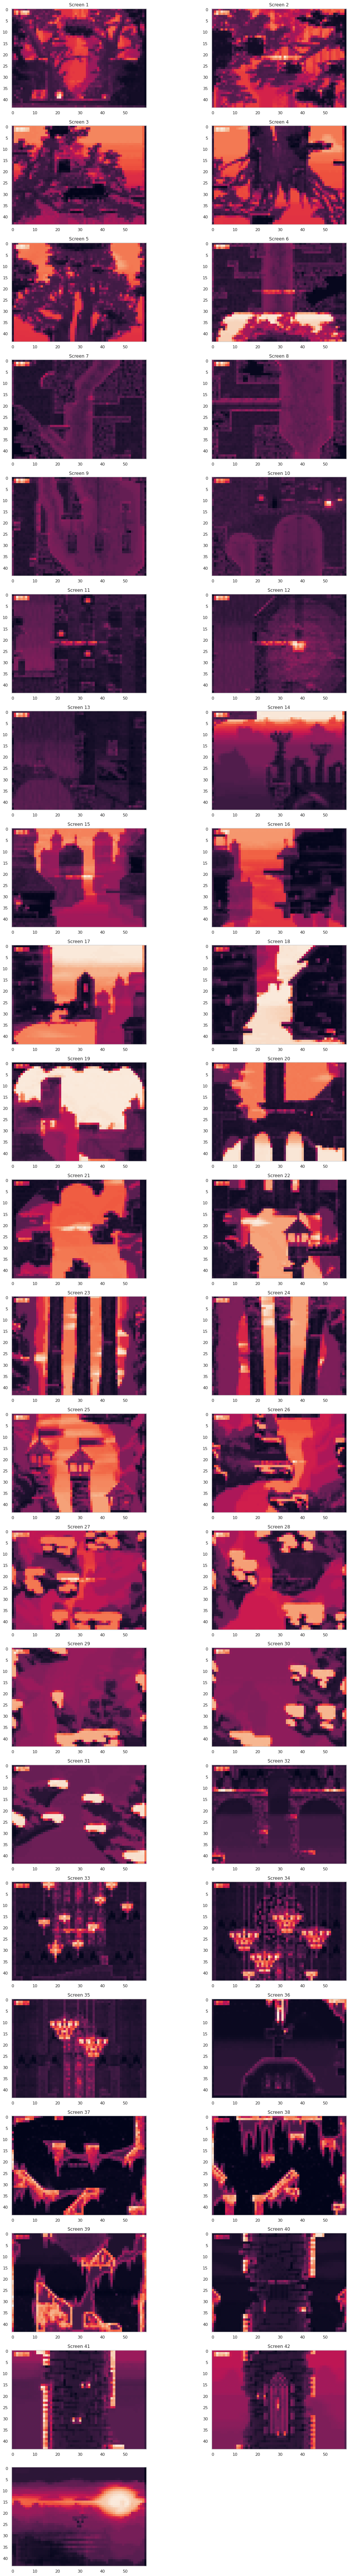

In [10]:
# check if all screens are present

fig, axs = plt.subplots(figsize=(16, 96))

for i, s in tqdm(enumerate(screen_to_frame.values())):
    plt.title(f"Screen {i}")
    plt.subplot(22, 2, i + 1)
    plt.imshow(s)

fig.tight_layout()
plt.show()

what am i going to present:

width 60 of every video

last screen corner case
detect not continuous video corner

find global position of game on screen
* calculate the number of unique pixels from the middle
* or KISS, detect the black line on top

time spent on each screen
* detect the screen using nearest neighbor
* get dictionary `{screen: [frames]}`
* for each screen calculate the proportion to the total time since start speedrun

heatmap of each screen
* detect the screen
* detect the kings location (relative to screen and absolute coordinates)
    * one shot object detection
    * opencv template matching
    * moving object detection (if does not move => previous location)
* produce heatmap

pipeline:
* map_screens.py and screen_to_frame.py for static files
* map_frames(filename, screen_to_frame)
* for each screen in screen to frames detect motion

https://www.sicara.ai/blog/en/object-detection-template-matching

https://debuggercafe.com/moving-object-detection-using-frame-differencing-with-opencv/

https://towardsdatascience.com/build-a-motion-heatmap-videousing-opencv-with-python-fd806e8a2340

https://github.com/kjw0612/awesome-deep-vision#imagenet-classification

-

https://www.pyimagesearch.com/2015/05/25/basic-motion-detection-and-tracking-with-python-and-opencv/

In [7]:
screen_to_frame = pickle.load(open("data/screen_to_frame.p", "rb"))
screen_to_frame = np.array([v.ravel() for v in screen_to_frame.values()])

In [8]:
screen_to_frames, frame_to_screen = map_frames('data/speedrun_side.mp4', screen_to_frame)

getting video start


  0%|          | 0/11277 [00:00<?, ?it/s]

video starts at frame 325
mapping screens


  0%|          | 0/10952 [00:00<?, ?it/s]

done mapping screens


In [9]:
cap = open_video('data/speedrun_side.mp4')
margin_left, margin_right = get_game_margins(cap)
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

True

In [13]:
screen_to_positions = {}  # {screen: [[x, y]]}
positions = []

# some screens are badly initialized

# if go back, then have to initialize screen_positions differently
# if go back, then have to jump to next frame first
for screen, frames in tqdm(screen_to_frames.items()):
    if screen == 42:
        continue
    for (start, end) in frames:
        n = end - start
        cap.set(cv2.CAP_PROP_POS_FRAMES, start)
        frames = []
        for i in range(n):
            ret, frame = cap.read()
            if ret == False:
                break

            frame = crop_margins(frame, margin_left, margin_right)
            frame = imutils.resize(frame, width=60)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(frame)

        avg_frame = np.mean(frames, axis=0).astype(np.uint8)
        cap.set(cv2.CAP_PROP_POS_FRAMES, start)
        if len(positions) != 0:
            x, _ = positions[-1]
            screen_positions = [(x, frame.shape[0])]
        else:
            screen_positions = [(30, 40)]

        for i in range(n):
            ret, frame = cap.read()
            if ret == False:
                break

            frame = crop_margins(frame, margin_left, margin_right)
            frame = imutils.resize(frame, width=60)
            orig_frame = frame.copy()

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame_diff = cv2.absdiff(avg_frame, frame)

            # exponential smoothing
            # TODO: if needed
            # avg_frame = (0.3 * frame + 0.7 * avg_frame).astype(np.uint8)

            ret, thres = cv2.threshold(frame_diff, 30, 255, cv2.THRESH_BINARY)
            dilate_frame = cv2.dilate(thres, None, iterations=2)

            contours, hierarchy = cv2.findContours(dilate_frame,
                                                   cv2.RETR_EXTERNAL,
                                                   cv2.CHAIN_APPROX_SIMPLE)

            for contour in contours:
                (x, y, w, h) = cv2.boundingRect(contour)
                cv2.rectangle(orig_frame, (x, y), (x + w, y + h), (0, 0, 255),
                              1)

            if len(contours) == 0:
                screen_positions.append(screen_positions[-1])
            elif len(contours) == 1:
                (x, y, w, h) = cv2.boundingRect(contours[0])
                if dist(screen_positions[-1], (x + w // 2, y + h // 2)) > 200:
                    #print("more than 50")
                    # detected another object
                    screen_positions.append(screen_positions[-1])
                else:
                    # print("her")
                    screen_positions.append((x + w // 2, y + h // 2))
            else:
                distances = []
                for contour in contours:
                    (x, y, w, h) = cv2.boundingRect(contour)
                    distances.append(
                        dist(screen_positions[-1], (x + w // 2, y + h // 2)))
                pidx = np.argmin(distances)
                (x, y, w, h) = cv2.boundingRect(contours[pidx])
                screen_positions.append((x + w // 2, y + h // 2))

            x, y = screen_positions[-1]

        positions = positions + screen_positions

  0%|          | 0/43 [00:00<?, ?it/s]

In [138]:
cap.release()

44x60 frame

y x

positions are
x y

In [14]:
positions

[(30, 40),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 39),
 (30, 37),
 (29, 36),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),
 (31, 39),

detect something like a box

if cannot => previous position

corner case first stage

In [ ]:
king = cv2.imread('data/king.webp')

In [ ]:
plt.imshow(king)

In [ ]:
king.shape